In [1]:
import numpy as np
import scipy as sp
import scipy.special as spec
from sklearn.preprocessing import normalize
%matplotlib inline
import matplotlib.pyplot as plt

# Defining functions:

In [2]:
def rho(tau,kappa,t):
    return (tau+t)**(-kappa)

In [3]:
def digamma(row):
    return spec.psi(row)-spec.psi(np.sum(row))

In [113]:
def lda(dtm,ntopic,tau,kappa,itemax):
    nvoc = dtm.shape[1]
    ndoc = dtm.shape[0]
    nu = 1./ndoc
    alpha = 1.
    
    topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
    intint = 100
    idx = range(ndoc)
    idx *= int(float(itemax)/ndoc)
    np.random.shuffle(idx)
    
    
    for t in range(itemax):
        old_topics = topics
        doc = idx[t]
        ids = np.nonzero(dtm[doc,:])[0]
        cts = dtm[doc,ids]
        gamma_ = gamma[doc,:]
        Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
        dott = lambda x: np.dot(x,cts)
        for tt in range(intint):
            old_gamma_ = gamma_
            Elogtheta = digamma(gamma_)
            E_sum = Elogbeta + Elogtheta
            phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
            gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
            if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.0001:
                break  
        gamma[doc,:] = gamma_
        topics_temp = nu + ndoc * phi * dtm[doc,ids][:, np.newaxis]
        rt = rho(tau,kappa,t)
        topics[ids,:] = (1-rt)*topics[ids,:] + rt*topics_temp
    
    return topics,gamma,tau,kappa

In [135]:
def inference(lda,newdocs,ite):
    alpha = 1
    
    topics = lda[0]
    tau = lda[2]
    kappa = lda[3]
    
    phi = np.random.gamma(100.,1./100.,(topics.shape))
    
    if len(newdocs.shape)==1:
        gamma_new  = np.random.gamma(100.,1./100.,(1,lda[1].shape[1]))
        for it in range(ite):
            ids = np.nonzero(newdocs)[0]
            cts = newdocs[ids]
            gamma_ = gamma_new
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            for tt in range(100):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.0001:
                    break  
            gamma_new = gamma_
            topics_temp = nu +  phi * cts[:, np.newaxis]
            rt = rho(tau,kappa,it)
            topics[ids,:] = (1-rt)*topics[ids,:] + rt*topics_temp
    
    else:
        gamma_new  = np.random.gamma(100.,1./100.,(newdocs.shape[0],lda[1].shape[1]))
        idx = range(newdocs.shape[0])
        idx *= ite
        np.random.shuffle(idx)
        for it in range(len(idx)):
            doc = idx[it]
            ids = np.nonzero(newdocs[doc,:])[0]
            cts = newdocs[doc,ids]
            gamma_ = gamma_new[doc,:]
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            for tt in range(100):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.0001:
                    break  
            gamma_new[doc,:] = gamma_
            topics_temp = nu +  phi * cts[:, np.newaxis]
            rt = rho(tau,kappa,it)
            topics[ids,:] = (1-rt)*topics[ids,:] + rt*topics_temp
            
    return topics,gamma_new

In [647]:
def show_topics(lda,whichtopic,topwords,wordlist):
    topics = lda[0]
    for t in whichtopic:
        idx = np.argsort(topics[:,t])[::-1][:topwords].astype(int)
        words = []
        for i in idx:
            words.append(wordlist[i])
        print "Topic %s:" % t
        print ""
        print words
        print ""

In [718]:
def perplexity_test(lda,newdocs,ite,perword = False):
    
    new = inference(lda,newdocs,ite)
    
    topics = new[0]
    gammas = new[1]
    
    topics = topics/topics.sum(axis=0)
    
    if len(gammas.shape) == 1:
        gammas = gammas/np.sum(gammas)
        doc_idx = np.nonzero(newdocs)[0]
        doc_cts = newdocs[doc_idx]
        return np.exp(-np.log(np.sum(np.dot(topics[doc_idx,:],gammas)*doc_cts))/np.sum(doc_cts))
    
    else:
        norm = lambda x: x/np.sum(x)
        gammas = np.apply_along_axis(norm,axis = 1,arr = gammas)
        
        num = 0
        denom = 0
        
        for i in range(gammas.shape[0]):
            doc_idx = np.nonzero(newdocs[i,:])[0]
            doc_cts = newdocs[i,doc_idx]
            num = np.sum(np.log(np.dot(topics[doc_idx,:],gammas[i,:]))*doc_cts)
            denom += np.sum(doc_cts)
            
        if ~perword:
            return num
        else:
            return num/denom

In [192]:
def perplexity_train(lda,dtm,docs_id):
    
    topics = lda[0]/lda[0].sum(axis=0)
    gammas = lda[1]/lda[1].sum(axis=1)[:, np.newaxis]
    
    if isinstance(docs_id, int) or len(docs_id) == 1:
        doc_idx = np.nonzero(dtm[docs_id,:])[0]
        doc_cts = dtm[docs_id,doc_idx]
        return np.exp(-np.log(np.sum(np.dot(topics[doc_idx,:],gammas[docs_id,:])*doc_cts))/np.sum(doc_cts))
    
    else:
        num = 0
        denom = 0
        
        for i in docs_id:
            doc_idx = np.nonzero(dtm[i,:])[0]
            doc_cts = dtm[docs_id,doc_idx]
            num -= np.log(np.sum(np.dot(topics[doc_idx,:],gammas[i,:])*doc_cts))
            denom += np.sum(doc_cts)
            
        return np.exp(num/denom)

In [677]:
def lda_minibatch(dtm,ntopic,mb_size,tau,kappa,itemax):
    nvoc = dtm.shape[1]
    ndoc = dtm.shape[0]
    nu = 1./ndoc
    alpha = 1./ndoc
    
    topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
    intint = 100
    idx = range(ndoc)
    #np.random.shuffle(idx)
    idx *= itemax
    #np.random.shuffle(idx)
    minibatchesids = np.array_split(idx,len(idx)/mb_size)
    
    for t in range(len(minibatchesids)):
        topics_temp = np.zeros(topics.shape)
        indices = []
        
        for id_ in minibatchesids[t]:
            doc = idx[id_]
            ids = np.nonzero(dtm[doc,:])[0]
            indices.extend(ids)
            cts = dtm[doc,ids]
            gamma_ = gamma[doc,:]
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            
            for tt in range(intint):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.000001:
                    break  
            gamma[doc,:] = gamma_
            topics_temp[ids,:] += phi * dtm[doc,ids][:, np.newaxis]
            
        indices  = np.unique(indices)
        topics_temp[indices,:] = nu + (ndoc/len(minibatchesids[t])) * topics_temp[indices,:]
        rt = rho(tau,kappa,t)
        topics[indices ,:] = (1-rt)*topics[indices,:] + rt*topics_temp[indices,:]
    
    return topics,gamma,tau,kappa

#Basic testing (Artficial corpuses)

In [2]:
dtm = np.zeros((100, 100))
dtm_ = np.zeros((10, 100))
for i in range(10):
    dtm_[i,] = [0]*10*i + [10]*10 + [0]*(10*(9-i))
for i in range(10):
    dtm[10*i:10*(i+1),]= dtm_

In [250]:
%%time
test = lda(dtm,10,10,0.5,300)

CPU times: user 268 ms, sys: 3.46 ms, total: 271 ms
Wall time: 281 ms


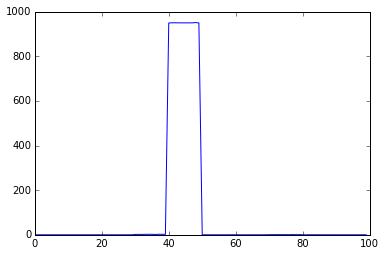

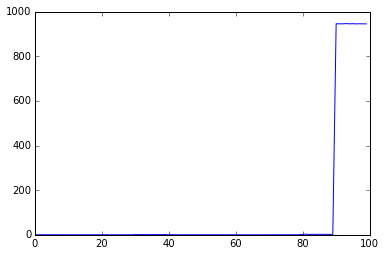

In [101]:
for i in range(2):
    plt.plot(range(100),test[0][:,i])
    plt.show()
    raw_input()
    

In [63]:
new_doc = [0]*100
new_doc[:10] = [5]*10
new_doc[90:] = [5]*10
new_doc = np.array(new_doc)

In [136]:
test2 = inference(test,new_doc,3)

In [137]:
test2[1]

array([  1.00016538,   1.00205872,   1.00006296,  50.99974546,
         1.        ,  50.99794627,   1.        ,   1.00000019,
         1.00000194,   1.00001908])

In [140]:
new_docs = np.zeros((2,100))
new_docs[0,:10] = [5]*10
new_docs[0,90:] = [5]*10
new_docs[1,10:20] = [5]*10
new_docs[1,80:90] = [5]*10

In [750]:
%%time
test4 = lda_minibatch(dtm,10,2,1024,0.9,100)

CPU times: user 3.47 s, sys: 11.3 ms, total: 3.48 s
Wall time: 3.49 s


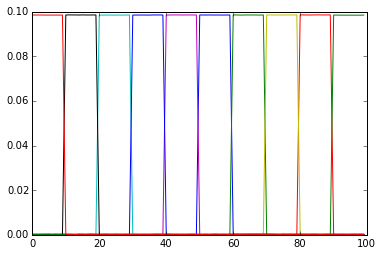

In [751]:
minibatchesids[10]

In [6]:
def lda_minibatch(dtm,ntopic,mb_size,tau,kappa,itemax):
    nvoc = dtm.shape[1]
    ndoc = dtm.shape[0]
    nu = 1./ndoc
    alpha = 1.
    
    topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
    intint = 100
    idx = range(ndoc)
    #np.random.shuffle(idx)
    idx *= itemax
    #np.random.shuffle(idx)
    minibatchesids = np.array_split(idx,len(idx)/mb_size)
    
    for t in range(len(minibatchesids)):
        topics_temp = np.zeros(topics.shape)
        indices = []
        
        for id_ in minibatchesids[t]:
            doc = idx[id_]
            ids = np.nonzero(dtm[doc,:])[0]
            indices.extend(ids)
            cts = dtm[doc,ids]
            gamma_ = gamma[doc,:]
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            
            for tt in range(intint):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.000001:
                    break  
            gamma[doc,:] = gamma_
            topics_temp[ids,:] += phi * dtm[doc,ids][:, np.newaxis]
            
        indices  = np.unique(indices)
        topics_temp[indices,:] = nu + (ndoc/len(minibatchesids[t])) * topics_temp[indices,:]
        rt = rho(tau,kappa,t)
        topics[indices ,:] = (1-rt)*topics[indices,:] + rt*topics_temp[indices,:]
    
    return topics,gamma,tau,kappa

In [17]:
%%time
test5 = lda_minibatch(corpus,9,1,512,0.9,100)

CPU times: user 10.8 s, sys: 96.6 ms, total: 10.9 s
Wall time: 11.1 s


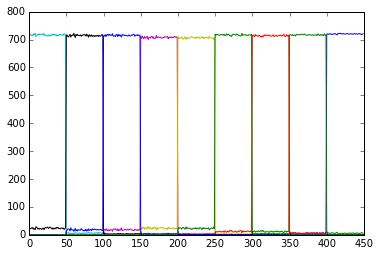

In [18]:
for i in range(9):
    plt.plot(range(450),test5[0][:,i])
plt.show()

In [719]:
perplexity_test(test5,corpus[80:,:],100)

-2063.5199273810185

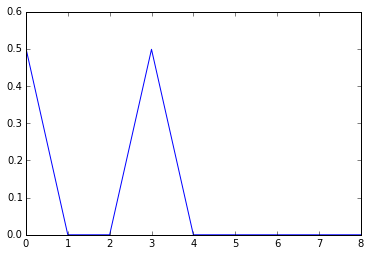

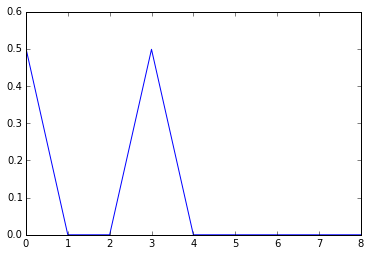

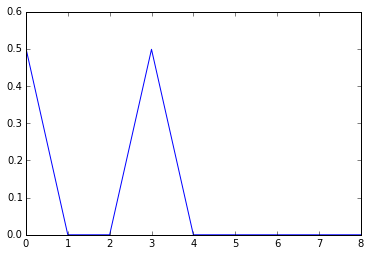

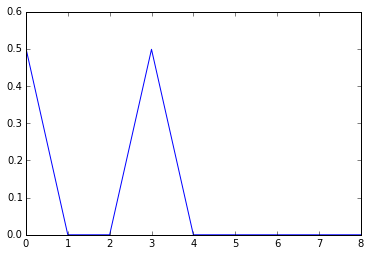

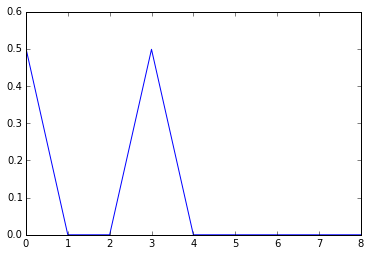

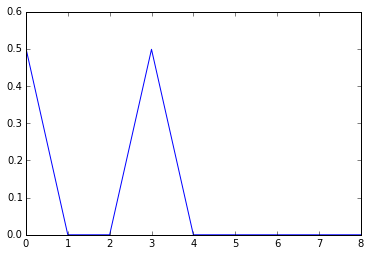

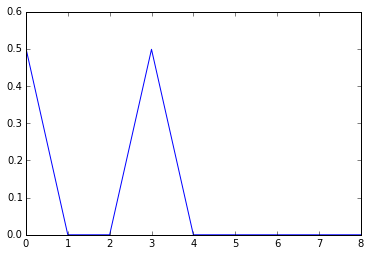

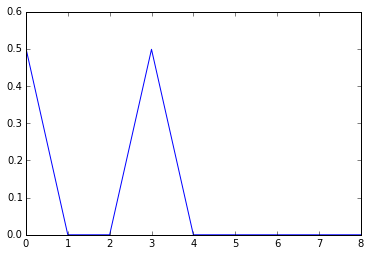

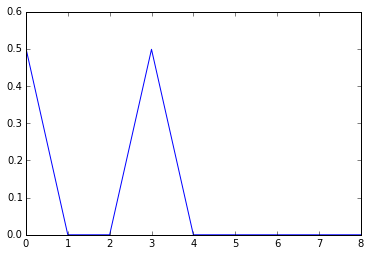

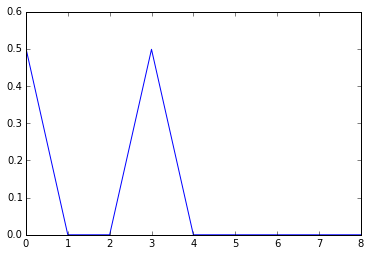

In [694]:
for i in range(10,20):
    plt.plot(range(9),test5[1][i,:]/sum(test5[1][i,:]))
    plt.show()
    raw_input()

# Test on Edimburgh words 

In [592]:
import json
with open('temp/edinburgh_word_adjective.json', 'r') as fp:
    edi = json.load(fp)

In [594]:
r0 = edi.keys()[0]

In [600]:
vocab = []
for i in edi.keys():
    vocab.extend(edi[i][0][0])

In [602]:
vocab = list(set(vocab))
len(vocab)

13224

In [4]:
word_to_index  = dict(zip(vocab,range(len(vocab))))
index_to_word = dict(zip(range(len(vocab)),vocab))

In [618]:
bid_to_index = dict(zip(edi.keys(),range(len(edi.keys()))))
index_to_bid = dict(zip(range(len(edi.keys())),edi.keys()))

In [609]:
import collections
from scipy import sparse

nonzero_data = []
rows_s = []
cols_s = []

for k in edi.keys():
    counter = collections.Counter(edi[k][0][0])
    nonzero_data += counter.values()
    rows_s += [bid_to_index[k]]*len(counter.values())
    cols_s += [word_to_index[ck] for ck in counter.keys()]

sparse_mat = sparse.csc_matrix((nonzero_data,(rows_s,cols_s)),shape = (len(bid_to_index),len(word_to_index)))

In [613]:
dtm_edi = sparse_mat.toarray()

In [621]:
type(dtm_edi)

numpy.ndarray

In [649]:
%%time
test_edi = lda_minibatch(dtm_edi,10,1,1024,0.9,50)

CPU times: user 5min 27s, sys: 2.14 s, total: 5min 29s
Wall time: 5min 34s


In [652]:
show_topics(test_edi,range(10),10,[w for w in vocab])

Topic 0:

[u'plank', u'enfant', u'assez', u'\xe7a', u'rissoto', u'taglioni', u'fran\xe7ais', u'les', u'pager', u'blade']

Topic 1:

[u'flavoury', u'mozzeralla', u'subway', u'papilio', u'vinyl', u'waverley', u'deliberate', u'shredder', u'toss', u'heather']

Topic 2:

[u'volunteer', u'workshop', u'subway', u'documentary', u'hygeine', u'scorn', u'human', u'hallucination', u'elitism', u'alrightttt']

Topic 3:

[u'war', u'da', u'immer', u'dass', u'es', u'alle', u'mit', u'f\xfcr', u'sich', u'zum']

Topic 4:

[u'food', u'place', u'burger', u'bar', u'restaurant', u'menu', u'pub', u'time', u'cocktail', u'dish']

Topic 5:

[u'hooligan', u'\xa36.99', u'inte', u'ta', u'divide', u'hinterher', u'einen', u'blank', u'froh', u'du']

Topic 6:

[u'kilo', u'einer', u'zwar', u'gro\xdfe', u'moule', u'tapferen', u'toujour', u'quickie', u'empfohlen', u'coeur']

Topic 7:

[u'subway', u'tipi', u'kids.it', u'princess', u'spud-u-like', u'reeeeeaaaaally', u'menu.thi', u'sniffer', u'macaron', u'workshop']

Topic 8:

In [653]:
nonzero_data = []
rows_s = []
cols_s = []

for k in edi.keys():
    countergeq5 = collections.Counter(edi[k][0][0])
    countergeq5 = counter.values()
    countergeq5[countergeq5<5] = 0
    nonzero_data += countergeq5
    rows_s += [bid_to_index[k]]*len(counter.values())
    cols_s += [word_to_index[ck] for ck in counter.keys()]

sparse_mat2 = sparse.csc_matrix((nonzero_data,(rows_s,cols_s)),shape = (len(bid_to_index),len(word_to_index)))

In [655]:
dtm_edi2 = sparse_mat2.toarray()

In [671]:
%%time
test_edi2 = lda_minibatch(dtm_edi2[:550,:],10,1,1024,0.9,50)

CPU times: user 4min 16s, sys: 2.43 s, total: 4min 18s
Wall time: 4min 25s


In [672]:
show_topics(test_edi2,range(10),10,vocab)

Topic 0:

[u'apparatus', u'distraction', u'\xa33.60', u'i.j', u'mensen', u'elderflower', u'peeps', u'herring', u'stud', u'soooooo']

Topic 1:

[u'australian', u'optimism', u'burgh', u'worry', u'regularity', u'bar-eaterie', u'personalisation', u'cubit', u'funghi', u'rincette']

Topic 2:

[u'offal', u'semi-icy', u'kwijt', u'littering', u'digestif', u'pillar', u'detractor', u'\xa31.00', u'lived-in', u'\xa35.25']

Topic 3:

[u'well-drawn', u'window-bench', u'protester', u'woo-hoo', u'sticking', u'homeliest', u'barbajuan', u'teatime', u'patchwork', u'browny']

Topic 4:

[u'shite', u'matin', u'cummin', u'host', u'envelope', u'didn;t', u'wheaty', u'mentality', u'insider', u'\xa37']

Topic 5:

[u'tempurad', u'peroni', u'dancing', u'mash', u'oyster', u'caliber', u'cosiness', u'cheeriest', u'sex', u'delicious-sounding']

Topic 6:

[u'food', u'place', u'dish', u'service', u'bit', u'vegetable', u'time', u'restaurant', u'rice', u'pickle']

Topic 7:

[u'briefing', u'kofte', u'swing-top', u'coinage',

In [673]:
perplexity_test(test_edi2,dtm_edi2[550:,:],50)

1.001833442466175

In [674]:
test_edi3 = lda_minibatch(dtm_edi2[:550,:],1,1,1024,0.9,50)

In [752]:
perplexity_test(test_edi3,dtm_edi2[550:,:],50)

-2812.8394423396931

In [753]:
test_edi4 = lda_minibatch(dtm_edi2[:550,:],1,1,1024,0.7,50)

In [754]:
perplexity_test(test_edi4,dtm_edi2[550:,:],50)

-2849.6234606686303